In [1]:
import numpy as np
import os
import time
import cv2
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

total_time_start= time.time()

# Set random seed for reproducibility
tf.random.set_seed(3)

# Load and preprocess data
folder_name = 'Dataset_BUSI_with_GT'
files_names = ['benign', 'malignant', 'normal']

def load_data_paths(folder_name=folder_name, files_names=files_names):
    data_paths = []
    labels = []
    for file in files_names:
        path = os.path.join(folder_name, file)
        class_num = files_names.index(file)
        for img in os.listdir(path):
            if "_mask" in img:  # Skip files with _mask in the filename
                continue
            try:
                img_path = os.path.join(path, img)
                data_paths.append(img_path)
                labels.append(class_num)
            except Exception as e:
                pass
    return np.array(data_paths), np.array(labels)
    
def data_generator(data_paths, labels, batch_size, img_sz, augment=False):
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    ) if augment else ImageDataGenerator()
    
    while True:
        indices = np.arange(len(data_paths))
        np.random.shuffle(indices)
        for start in range(0, len(data_paths), batch_size):
            end = min(start + batch_size, len(data_paths))
            batch_indices = indices[start:end]
            batch_images = []
            batch_labels = []
            for i in batch_indices:
                img = cv2.imread(data_paths[i], cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_sz, img_sz))
                img = img / 255.0
                batch_images.append(img)
                batch_labels.append(labels[i])
            batch_images = np.array(batch_images).reshape(-1, img_sz, img_sz, 1)
            batch_labels = to_categorical(batch_labels, num_classes=3)
            yield batch_images, batch_labels

# Define the CNN model function
def create_model(img_sz):
    model = Sequential([
        # Convolutional Layer
        Conv2D(128, (3, 3), activation='relu', input_shape=(img_sz, img_sz, 1)),

        # Max Pooling Layer
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening Layer
        Flatten(),

        # Dense Layer
        Dense(128, activation='relu'),
        
        Dropout(0.5),
        
        # Output layer (3 classes: benign, malignant and normal)
        Dense(3, activation='softmax')
        
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

2024-08-24 09:29:17.014902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 09:29:17.051982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 09:29:17.052562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 09:29:17.643917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load all data paths and labels
data_paths, labels = load_data_paths()

# K-Fold Cross-Validation
kf = KFold(n_splits=2, shuffle=True, random_state=123)

# Store results
accuracy_scores = []
batch_size = 32
img_sz = 128

In [3]:
for train_index, val_index in kf.split(data_paths):
    train_paths, val_paths = data_paths[train_index], data_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    train_generator = data_generator(train_paths, train_labels, batch_size, img_sz, augment=True)
    val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
    
    model = create_model(img_sz)
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(train_generator,
                        steps_per_epoch=len(train_paths) // batch_size,
                        epochs=3, 
                        validation_data=val_generator,
                        validation_steps=len(val_paths) // batch_size,
                        callbacks=[early_stopping])
    
    # Evaluate the model
    val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
    loss, accuracy = model.evaluate(val_generator, steps=len(val_paths) // batch_size)
    accuracy_scores.append(accuracy)
    print(f"Fold accuracy: {accuracy * 100:.2f}%")

# Calculate average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")

2024-08-24 09:29:18.121324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-24 09:29:18.154636: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/3
12/12 [==============================] - 10s 809ms/step - loss: 3.7718 - accuracy: 0.4062 - val_loss: 0.9388 - val_accuracy: 0.5781
Epoch 2/3
12/12 [==============================] - 9s 759ms/step - loss: 0.9844 - accuracy: 0.5950 - val_loss: 0.8864 - val_accuracy: 0.6453
Epoch 3/3
12/12 [==============================] - 2s 157ms/step - loss: 0.8062 - accuracy: 0.6484
Fold accuracy: 64.84%
Epoch 1/3
12/12 [==============================] - 9s 779ms/step - loss: 5.0980 - accuracy: 0.4635 - val_loss: 1.0465 - val_accuracy: 0.5651
Epoch 2/3
12/12 [==============================] - 9s 750ms/step - loss: 1.1162 - accuracy: 0.5223 - val_loss: 0.9443 - val_accuracy: 0.6173
Epoch 3/3
12/12 [==============================] - 2s 161ms/step - loss: 0.8957 - accuracy: 0.5938
Fold accuracy: 59.38%
Average Accuracy: 62.11%


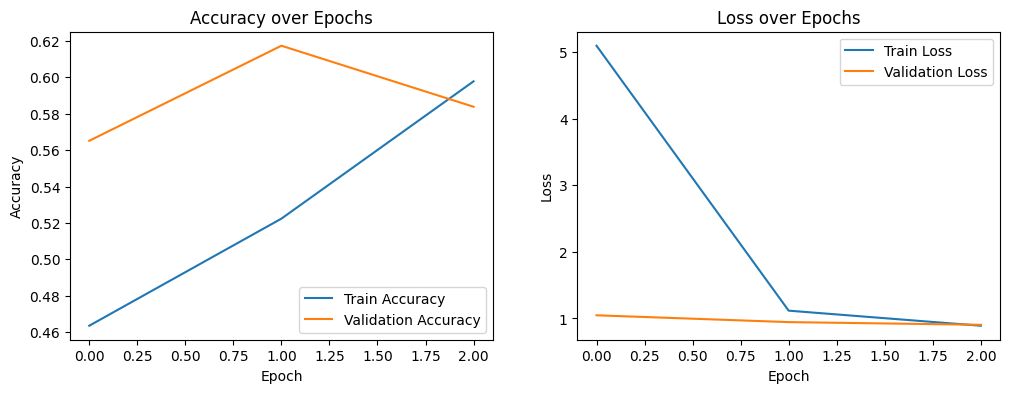

In [4]:
# Plot training history for the last fold
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

Improving the training and evaluation loop to keep track of more statistics not just accuracy over epochs. But also ROC-AUC, F1, Accuracy, and the training time

In [5]:
# Metrics to track
accuracy_scores = []
auc_scores = []
f1_scores = []
training_times = []

for train_index, val_index in kf.split(data_paths):
    train_paths, val_paths = data_paths[train_index], data_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    train_generator = data_generator(train_paths, train_labels, batch_size, img_sz, augment=True)
    val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
    
    model = create_model(img_sz)
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    # Measure time taken for training
    start_time = time.time()

    # Train the model
    history = model.fit(train_generator,
                        steps_per_epoch=len(train_paths) // batch_size,
                        epochs=2, 
                        validation_data=val_generator,
                        validation_steps=len(val_paths) // batch_size,
                        callbacks=[early_stopping])
    
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)
    
    # Evaluate the model and calculate additional metrics
    val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
    predictions = model.predict(val_generator, steps=len(val_paths) // batch_size)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = val_labels[:len(pred_labels)]  # Ensure the labels match the predictions
    true_labels_one_hot = to_categorical(true_labels, num_classes=3)

    # Calculate accuracy, ROC AUC, and F1 score
    accuracy = np.mean(pred_labels == np.argmax(true_labels_one_hot, axis=1))
    auc = roc_auc_score(true_labels_one_hot, predictions, multi_class='ovr')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    accuracy_scores.append(accuracy)
    auc_scores.append(auc)
    f1_scores.append(f1)
    
    print(f"Fold accuracy: {accuracy * 100:.2f}%, ROC AUC: {auc:.2f}, F1 Score: {f1:.2f}, Training time: {training_time:.2f}s")

    tf.keras.backend.clear_session()

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_auc = np.mean(auc_scores)
average_f1 = np.mean(f1_scores)
average_time = np.mean(training_times)

print(f"Average Accuracy: {average_accuracy * 100:.2f}%, Average ROC AUC: {average_auc:.2f}, Average F1 Score: {average_f1:.2f}, Average Training Time: {average_time:.2f}s")

Epoch 1/2
12/12 [==============================] - 9s 777ms/step - loss: 5.4317 - accuracy: 0.4479 - val_loss: 1.2900 - val_accuracy: 0.5938
Epoch 2/2
12/12 [==============================] - 2s 153ms/step
Fold accuracy: 53.39%, ROC AUC: 0.52, F1 Score: 0.47, Training time: 18.20s
Epoch 1/2
12/12 [==============================] - 9s 769ms/step - loss: 3.2269 - accuracy: 0.4896 - val_loss: 1.1047 - val_accuracy: 0.5833
Epoch 2/2
12/12 [==============================] - 2s 155ms/step
Fold accuracy: 53.65%, ROC AUC: 0.52, F1 Score: 0.37, Training time: 18.03s
Average Accuracy: 53.52%, Average ROC AUC: 0.52, Average F1 Score: 0.42, Average Training Time: 18.12s


In [6]:
# cleanup as RAM is precious

del history, val_generator, predictions, true_labels, true_labels_one_hot

In [7]:
def evaluate_model_kfold(folder_name, files_names, img_sz, create_model_func, n_splits=5, epochs=2, batch_size=32, **kwargs):
    # Load data paths and labels
    data_paths, labels = load_data_paths(folder_name=folder_name, files_names=files_names)

    # Metrics to track
    accuracy_scores = []
    auc_scores = []
    f1_scores = []
    training_times = []

    # K-Fold Cross-Validation setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)

    for train_index, val_index in kf.split(data_paths):
        train_paths, val_paths = data_paths[train_index], data_paths[val_index]
        train_labels, val_labels = labels[train_index], labels[val_index]
        
        train_generator = data_generator(train_paths, train_labels, batch_size, img_sz, augment=True)
        val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
        
        model = create_model_func(img_sz, **kwargs)
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        
        # Measure time taken for training
        start_time = time.time()

        # Train the model
        history = model.fit(train_generator,
                            steps_per_epoch=len(train_paths) // batch_size,
                            epochs=epochs, 
                            validation_data=val_generator,
                            validation_steps=len(val_paths) // batch_size,
                            callbacks=[early_stopping])
        
        end_time = time.time()
        training_time = end_time - start_time
        training_times.append(training_time)
        
        # Evaluate the model and calculate additional metrics
        val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
        predictions = model.predict(val_generator, steps=len(val_paths) // batch_size)
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = val_labels[:len(pred_labels)]  # Ensure the labels match the predictions
        true_labels_one_hot = to_categorical(true_labels, num_classes=3)

        # Calculate accuracy, ROC AUC, and F1 score
        accuracy = np.mean(pred_labels == np.argmax(true_labels_one_hot, axis=1))
        auc = roc_auc_score(true_labels_one_hot, predictions, multi_class='ovr')
        f1 = f1_score(true_labels, pred_labels, average='weighted')

        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        f1_scores.append(f1)
        
        tf.keras.backend.clear_session()

    # Calculate average metrics across all folds
    average_accuracy = np.mean(accuracy_scores)
    average_auc = np.mean(auc_scores)
    average_f1 = np.mean(f1_scores)
    average_time = np.mean(training_times)

    return {
        'accuracy': average_accuracy,
        'roc_auc': average_auc,
        'f1_score': average_f1,
        'training_time': average_time
    }

In [8]:
image_results = {}
total_start_time = time.time()
for image_size in [50, 100, 150, 200, 250]:  #commented out 300 because running notebook from top to bottom does not have enough RAM
    print("\n Image Size {} \n".format(image_size))

    if image_size < 200:
        image_results[image_size] = evaluate_model_kfold(folder_name=folder_name, 
                                                         files_names=files_names, 
                                                         img_sz=image_size, 
                                                         create_model_func=create_model, 
                                                         n_splits=2, 
                                                         epochs=2, 
                                                         batch_size=50)
    elif image_size <= 250:
        image_results[image_size] = evaluate_model_kfold(folder_name=folder_name, 
                                                         files_names=files_names, 
                                                         img_sz=image_size, 
                                                         create_model_func=create_model, 
                                                         n_splits=2, 
                                                         epochs=2, 
                                                         batch_size=38)
    else:
        image_results[image_size] = evaluate_model_kfold(folder_name=folder_name, 
                                                     files_names=files_names, 
                                                     img_sz=image_size, 
                                                     create_model_func=create_model, 
                                                     n_splits=2, 
                                                     epochs=2, 
                                                     batch_size=4)
total_end_time = time.time()
print("total image size comparison time {}".format(total_end_time-total_start_time))


 Image Size 50 

Epoch 1/2
7/7 [==============================] - 3s 510ms/step - loss: 1.3977 - accuracy: 0.4143 - val_loss: 0.9369 - val_accuracy: 0.5857
Epoch 2/2
7/7 [==============================] - 1s 200ms/step
Epoch 1/2
7/7 [==============================] - 3s 509ms/step - loss: 1.6767 - accuracy: 0.4286 - val_loss: 1.2172 - val_accuracy: 0.5229
Epoch 2/2
7/7 [==============================] - 1s 201ms/step

 Image Size 100 

Epoch 1/2
7/7 [==============================] - 6s 778ms/step - loss: 3.1808 - accuracy: 0.4457 - val_loss: 1.0586 - val_accuracy: 0.6200
Epoch 2/2
7/7 [==============================] - 1s 216ms/step
Epoch 1/2
7/7 [==============================] - 5s 750ms/step - loss: 8.3612 - accuracy: 0.4400 - val_loss: 4.4755 - val_accuracy: 0.5200
Epoch 2/2
7/7 [==============================] - 1s 220ms/step

 Image Size 150 

Epoch 1/2
7/7 [==============================] - 9s 1s/step - loss: 11.7688 - accuracy: 0.4257 - val_loss: 1.3848 - val_accuracy: 0.6029

In [9]:
image_results = pd.DataFrame(image_results).T

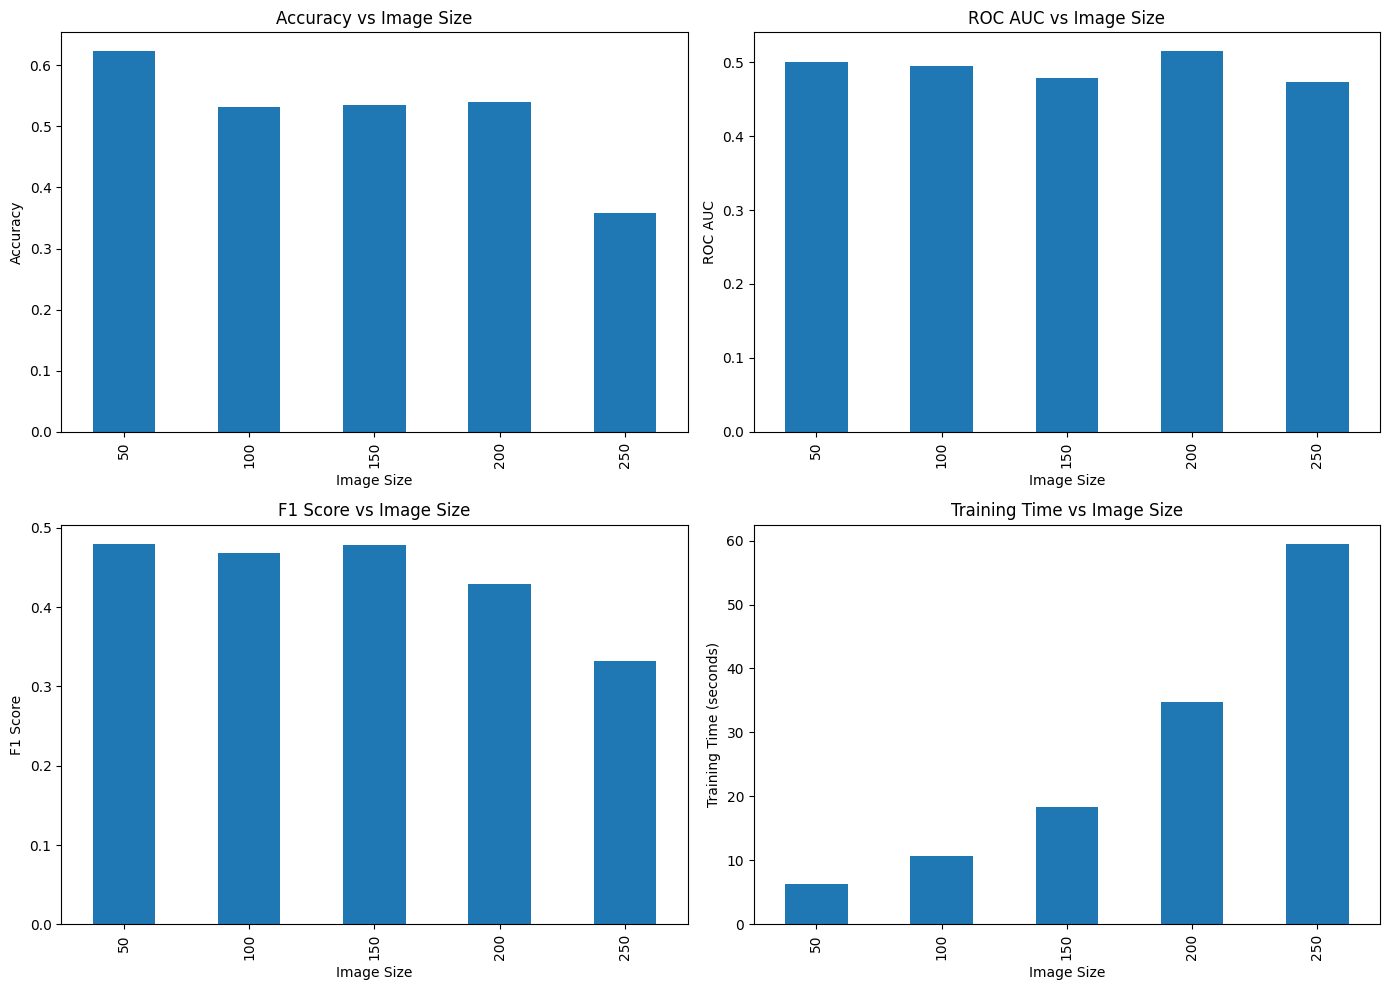

In [10]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy bar plot
image_results['accuracy'].plot(kind='bar', ax=axes[0,0], title='Accuracy vs Image Size')
axes[0,0].set_xlabel('Image Size')
axes[0,0].set_ylabel('Accuracy')

# ROC AUC bar plot
image_results['roc_auc'].plot(kind='bar', ax=axes[0,1], title='ROC AUC vs Image Size')
axes[0,1].set_xlabel('Image Size')
axes[0,1].set_ylabel('ROC AUC')

# F1 Score bar plot
image_results['f1_score'].plot(kind='bar', ax=axes[1,0], title='F1 Score vs Image Size')
axes[1,0].set_xlabel('Image Size')
axes[1,0].set_ylabel('F1 Score')

# Training Time bar plot
image_results['training_time'].plot(kind='bar', ax=axes[1,1], title='Training Time vs Image Size')
axes[1,1].set_xlabel('Image Size')
axes[1,1].set_ylabel('Training Time (seconds)')

# Display the plots
plt.tight_layout()
plt.show()

<Axes: title={'center': 'F1 Score vs Training Time'}>

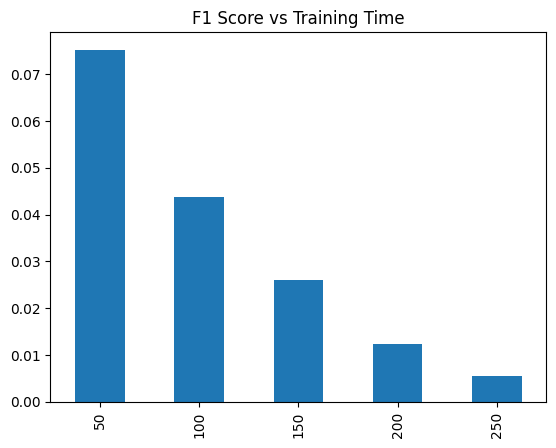

In [11]:
(image_results['f1_score']/image_results['training_time']).plot(kind='bar', title="F1 Score vs Training Time")

So for maximum F1 score and a CPU resource time optimizaton. The best performer is 100 PX

In [12]:
def evaluate_model_stratified_kfold(folder_name, files_names, img_sz, create_model_func, n_splits=5, epochs=2, batch_size=32,
                                    training_histories=False, **kwargs):
    # Load data paths and labels
    data_paths, labels = load_data_paths(folder_name=folder_name, files_names=files_names)

        # Metrics to track
    accuracy_scores = []
    auc_scores = []
    f1_scores = []
    training_times = []
    training_histories = []  # Store the history for each fold

    # Stratified K-Fold Cross-Validation setup
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    
    for train_index, val_index in skf.split(data_paths, labels):
        train_paths, val_paths = data_paths[train_index], data_paths[val_index]
        train_labels, val_labels = labels[train_index], labels[val_index]
        
        train_generator = data_generator(train_paths, train_labels, batch_size, img_sz, augment=True)
        val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
        
        model = create_model_func(img_sz, **kwargs)
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        
        # Measure time taken for training
        start_time = time.time()
    
        # Train the model
        history = model.fit(train_generator,
                            steps_per_epoch=len(train_paths) // batch_size,
                            epochs=epochs, 
                            validation_data=val_generator,
                            validation_steps=len(val_paths) // batch_size,
                            callbacks=[early_stopping])
        
        end_time = time.time()
        training_time = end_time - start_time
        training_times.append(training_time)
        # Append the history of this fold
        training_histories.append(history.history)
        # Evaluate the model and calculate additional metrics
        val_generator = data_generator(val_paths, val_labels, batch_size, img_sz, augment=False)
        predictions = model.predict(val_generator, steps=len(val_paths) // batch_size)
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = val_labels[:len(pred_labels)]  # Ensure the labels match the predictions
        true_labels_one_hot = to_categorical(true_labels, num_classes=3)
    
        # Calculate accuracy, ROC AUC, and F1 score
        accuracy = np.mean(pred_labels == np.argmax(true_labels_one_hot, axis=1))
        auc = roc_auc_score(true_labels_one_hot, predictions, multi_class='ovr')
        f1 = f1_score(true_labels, pred_labels, average='weighted')
    
        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        f1_scores.append(f1)
            
        tf.keras.backend.clear_session()
    
    # Calculate average metrics across all folds
    average_accuracy = np.mean(accuracy_scores)
    average_auc = np.mean(auc_scores)
    average_f1 = np.mean(f1_scores)
    average_time = np.mean(training_times)

    if training_histories:
        return {
            'accuracy': average_accuracy,
            'roc_auc': average_auc,
            'f1_score': average_f1,
            'training_time': average_time
        }, training_histories

    else:
        return {
            'accuracy': average_accuracy,
            'roc_auc': average_auc,
            'f1_score': average_f1,
            'training_time': average_time
        }

In [13]:
kfold_results = {}
kfold_results['normal']=  evaluate_model_kfold(folder_name=folder_name, 
                                                         files_names=files_names, 
                                                         img_sz=100, 
                                                         create_model_func=create_model, 
                                                         n_splits=5, 
                                                         epochs=2, 
                                                         batch_size=50)

kfold_results['stratified'], histories = evaluate_model_stratified_kfold(folder_name=folder_name, 
                                                         files_names=files_names, 
                                                         img_sz=100, 
                                                         create_model_func=create_model, 
                                                         n_splits=5, 
                                                         epochs=2, 
                                                         batch_size=50)

Epoch 1/2
12/12 [==============================] - 8s 566ms/step - loss: 4.4172 - accuracy: 0.4133 - val_loss: 1.0834 - val_accuracy: 0.3933
Epoch 2/2
3/3 [==============================] - 1s 221ms/step
Epoch 1/2
12/12 [==============================] - 7s 549ms/step - loss: 4.4926 - accuracy: 0.4450 - val_loss: 0.8241 - val_accuracy: 0.6933
Epoch 2/2
3/3 [==============================] - 1s 232ms/step
Epoch 1/2
12/12 [==============================] - 7s 554ms/step - loss: 2.5448 - accuracy: 0.4750 - val_loss: 0.9855 - val_accuracy: 0.5533
Epoch 2/2
3/3 [==============================] - 1s 218ms/step
Epoch 1/2
12/12 [==============================] - 7s 551ms/step - loss: 3.9023 - accuracy: 0.4950 - val_loss: 1.2304 - val_accuracy: 0.4933
Epoch 2/2
3/3 [==============================] - 1s 218ms/step
Epoch 1/2
12/12 [==============================] - 7s 548ms/step - loss: 4.1801 - accuracy: 0.4600 - val_loss: 1.0282 - val_accuracy: 0.6267
Epoch 2/2
3/3 [============================

In [14]:
kfold_results

{'normal': {'accuracy': 0.5813333333333334,
  'roc_auc': 0.5094082494930884,
  'f1_score': 0.44544507048592835,
  'training_time': 13.389780712127685},
 'stratified': {'accuracy': 0.584,
  'roc_auc': 0.512690603788509,
  'f1_score': 0.4319942028212571,
  'training_time': 12.695503044128419}}

In [15]:
kfold_results = pd.DataFrame(kfold_results).T

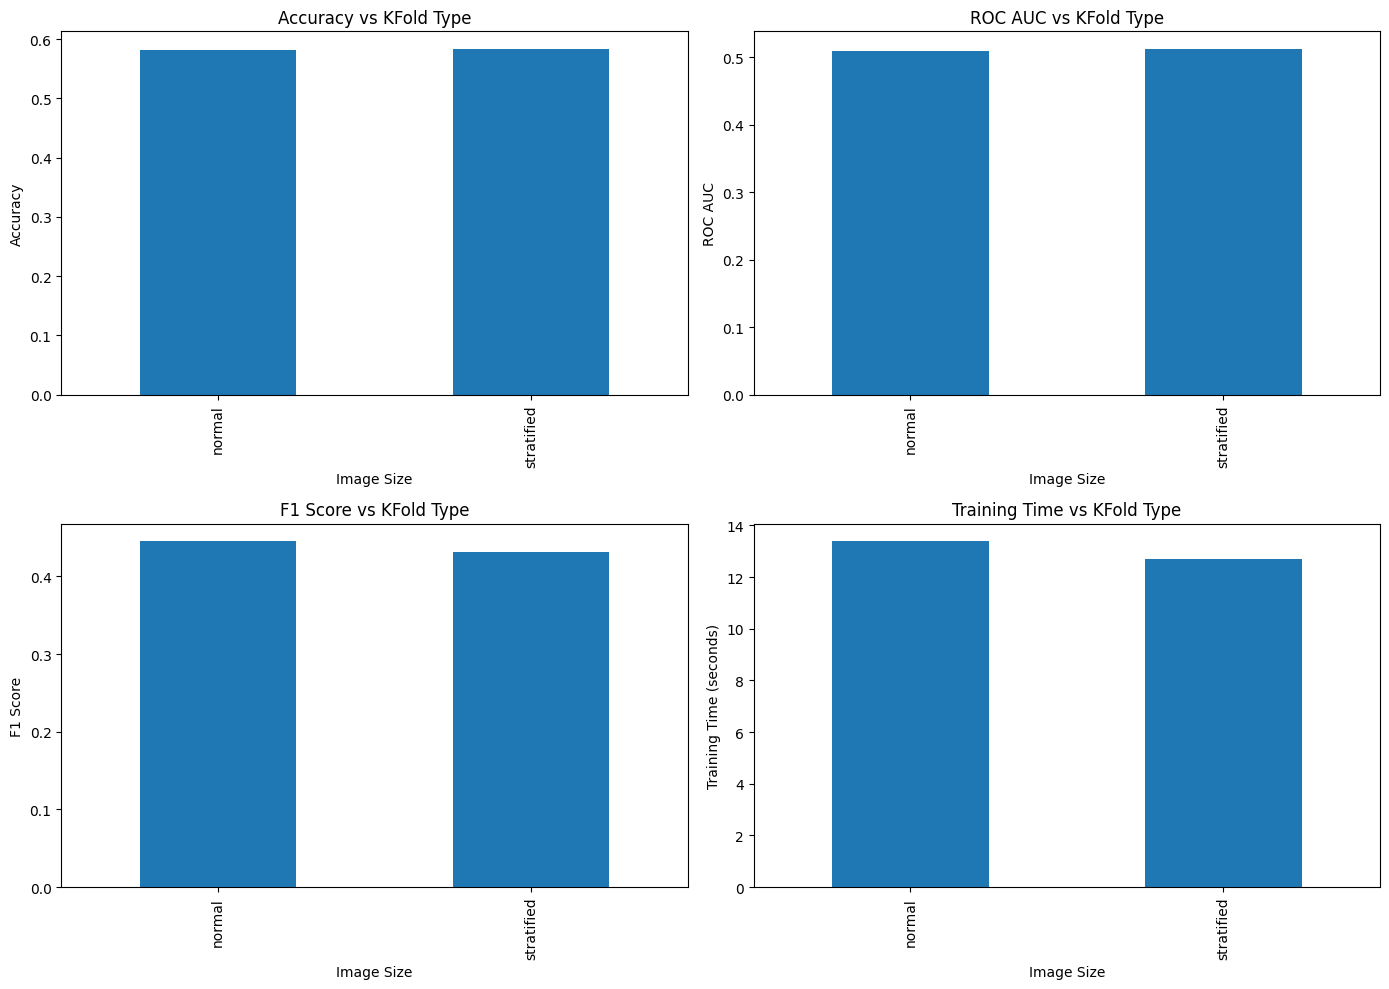

In [16]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy bar plot
kfold_results['accuracy'].plot(kind='bar', ax=axes[0,0], title='Accuracy vs KFold Type')
axes[0,0].set_xlabel('Image Size')
axes[0,0].set_ylabel('Accuracy')

# ROC AUC bar plot
kfold_results['roc_auc'].plot(kind='bar', ax=axes[0,1], title='ROC AUC vs KFold Type')
axes[0,1].set_xlabel('Image Size')
axes[0,1].set_ylabel('ROC AUC')

# F1 Score bar plot
kfold_results['f1_score'].plot(kind='bar', ax=axes[1,0], title='F1 Score vs KFold Type')
axes[1,0].set_xlabel('Image Size')
axes[1,0].set_ylabel('F1 Score')

# Training Time bar plot
kfold_results['training_time'].plot(kind='bar', ax=axes[1,1], title='Training Time vs KFold Type')
axes[1,1].set_xlabel('Image Size')
axes[1,1].set_ylabel('Training Time (seconds)')

# Display the plots
plt.tight_layout()
plt.show()

<Axes: title={'center': 'F1 Score vs Training Time'}>

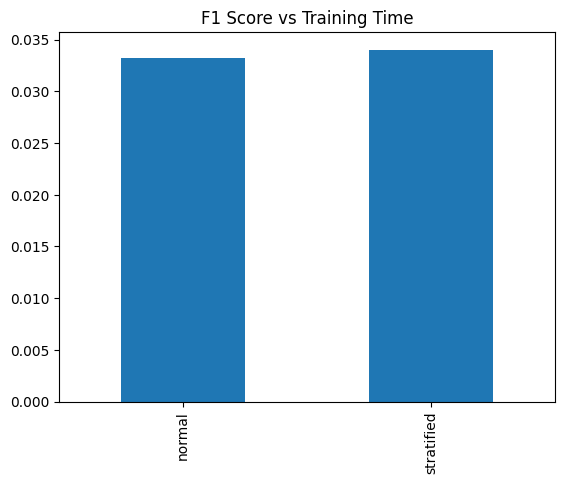

In [17]:
(kfold_results['f1_score']/kfold_results['training_time']).plot(kind='bar', title="F1 Score vs Training Time")

In [18]:
(kfold_results['f1_score']/kfold_results['training_time'])

normal        0.033268
stratified    0.034027
dtype: float64

<Axes: title={'center': 'F1 Score vs Training Time'}>

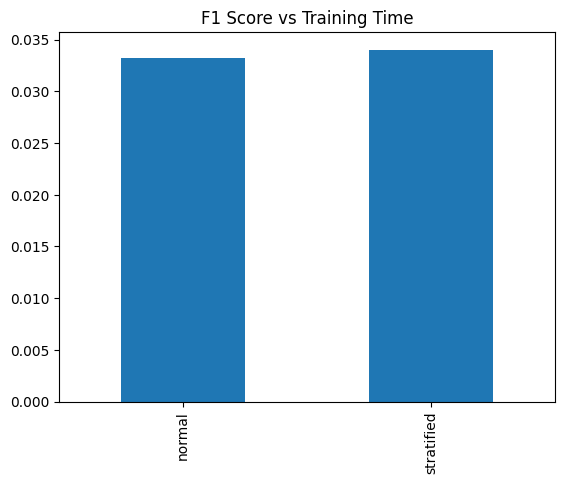

In [19]:
(kfold_results['f1_score']/kfold_results['training_time']).plot(kind='bar', title="F1 Score vs Training Time")

I Tried stratefied KFOLD the results are similar in F1 vs speed. However stratified does have a better accuracy so i will stick with that

In [20]:
epoch_results = {}
total_start_time = time.time()
histories = list()
for epoch in [2, 4, 6, 8, 10]:
    print("\n Epoch {} \n".format(epoch))
    epoch_results[epoch], current_history = evaluate_model_stratified_kfold(folder_name=folder_name, 
                                                         files_names=files_names, 
                                                         img_sz=100, 
                                                         create_model_func=create_model, 
                                                         n_splits=5, 
                                                         epochs=epoch, 
                                                         batch_size=50)
    histories.append(current_history)

total_end_time = time.time()
print("total image size comparison time {}".format(total_end_time-total_start_time))


 Epoch 2 

Epoch 1/2
12/12 [==============================] - 7s 578ms/step - loss: 2.7782 - accuracy: 0.4850 - val_loss: 0.9703 - val_accuracy: 0.5400
Epoch 2/2
3/3 [==============================] - 1s 240ms/step
Epoch 1/2
12/12 [==============================] - 7s 546ms/step - loss: 4.9553 - accuracy: 0.4883 - val_loss: 1.3269 - val_accuracy: 0.5667
Epoch 2/2
3/3 [==============================] - 1s 216ms/step
Epoch 1/2
12/12 [==============================] - 7s 550ms/step - loss: 4.2279 - accuracy: 0.5067 - val_loss: 1.3147 - val_accuracy: 0.4800
Epoch 2/2
3/3 [==============================] - 1s 236ms/step
Epoch 1/2
12/12 [==============================] - 7s 543ms/step - loss: 2.5458 - accuracy: 0.4483 - val_loss: 0.9825 - val_accuracy: 0.5933
Epoch 2/2
3/3 [==============================] - 1s 219ms/step
Epoch 1/2
12/12 [==============================] - 7s 537ms/step - loss: 3.3157 - accuracy: 0.4450 - val_loss: 0.9607 - val_accuracy: 0.5867
Epoch 2/2
3/3 [================

In [21]:
epoch_results

{2: {'accuracy': 0.5666666666666668,
  'roc_auc': 0.4813496960903668,
  'f1_score': 0.43491766830236767,
  'training_time': 13.095966100692749},
 4: {'accuracy': 0.56,
  'roc_auc': 0.5082122666782495,
  'f1_score': 0.44942687090490024,
  'training_time': 24.54912977218628},
 6: {'accuracy': 0.5093333333333333,
  'roc_auc': 0.5112025600004778,
  'f1_score': 0.44709527330247295,
  'training_time': 36.909607315063475},
 8: {'accuracy': 0.4893333333333333,
  'roc_auc': 0.48897189879062497,
  'f1_score': 0.4488909812287015,
  'training_time': 46.924044609069824},
 10: {'accuracy': 0.5026666666666666,
  'roc_auc': 0.4667578705257709,
  'f1_score': 0.44721541647534624,
  'training_time': 62.157242155075075}}

In [22]:
epoch_results = pd.DataFrame(epoch_results).T

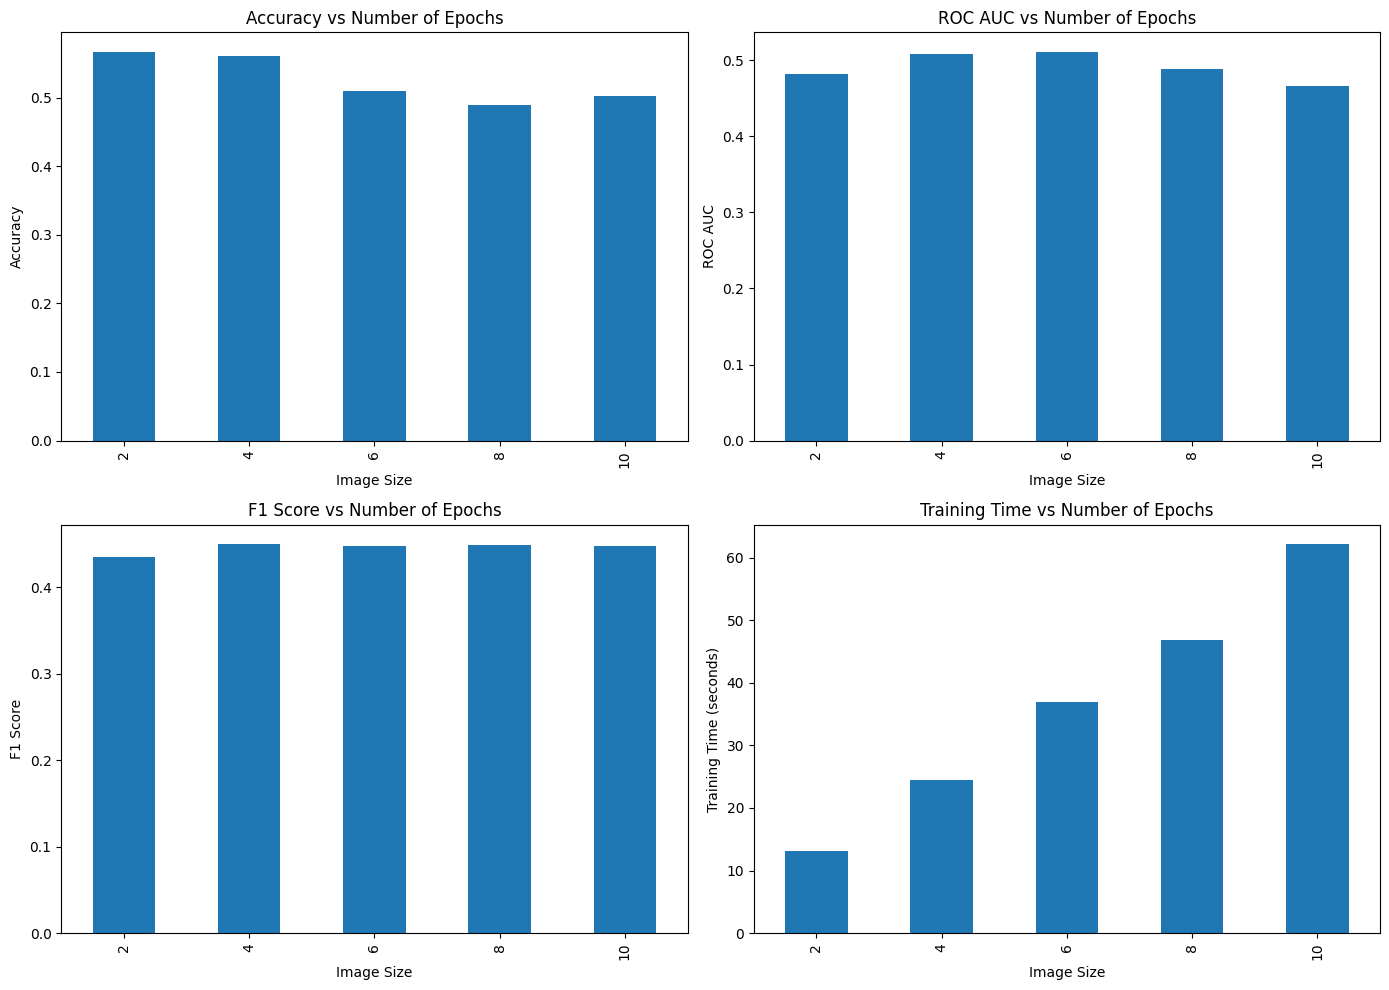

In [23]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy bar plot
epoch_results['accuracy'].plot(kind='bar', ax=axes[0,0], title='Accuracy vs Number of Epochs')
axes[0,0].set_xlabel('Image Size')
axes[0,0].set_ylabel('Accuracy')

# ROC AUC bar plot
epoch_results['roc_auc'].plot(kind='bar', ax=axes[0,1], title='ROC AUC vs Number of Epochs')
axes[0,1].set_xlabel('Image Size')
axes[0,1].set_ylabel('ROC AUC')

# F1 Score bar plot
epoch_results['f1_score'].plot(kind='bar', ax=axes[1,0], title='F1 Score vs Number of Epochs')
axes[1,0].set_xlabel('Image Size')
axes[1,0].set_ylabel('F1 Score')

# Training Time bar plot
epoch_results['training_time'].plot(kind='bar', ax=axes[1,1], title='Training Time vs Number of Epochs')
axes[1,1].set_xlabel('Image Size')
axes[1,1].set_ylabel('Training Time (seconds)')

# Display the plots
plt.tight_layout()
plt.show()

<Axes: title={'center': 'F1 Score vs Training Time'}>

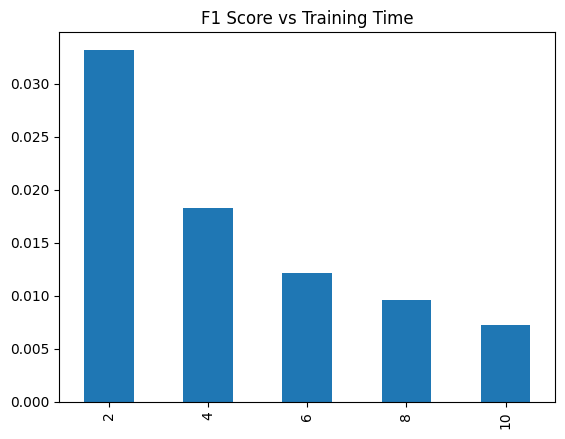

In [24]:
(epoch_results['f1_score']/epoch_results['training_time']).plot(kind='bar', title="F1 Score vs Training Time")

There isnt not really any big changes in adding more epochs,2 has the best accuracy and ROC AUC. F1 is relatively flat over adding epochs and it adds a lot of compute time for not much more results.

In [25]:
def create_dynamic_model(img_sz, model_depth_blocks):
    model = Sequential()
    
    # Start with the first convolutional layer with 8 filters
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(img_sz, img_sz, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    current_size = img_sz
    # Gradually increase the number of filters by adding a small constant increment
    for i in range(1, model_depth_blocks):
        if current_size <= 3:
            break  # Stop adding more layers if the size is too small
        num_filters = 8 * (2 ** i)  # Exponential increase in the number of filters
        model.add(Conv2D(num_filters, (3, 3), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        current_size = current_size // 2  # Update the current size after each pooling layer

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [26]:
depth_results = {}
total_start_time = time.time()
histories = list()
for depth in range(0, 12, 2):
    print(f"Testing model with {depth} depth blocks")
    results, current_history= evaluate_model_stratified_kfold(
        folder_name=folder_name, 
        files_names=files_names, 
        img_sz=100, 
        create_model_func=create_dynamic_model, 
        n_splits=5, 
        epochs=10, 
        batch_size=50, 
        model_depth_blocks=depth
    )
    depth_results[depth] = results
    histories.append(current_history)
total_end_time = time.time()
print("total depth_results comparison time {}".format(total_end_time-total_start_time))

Testing model with 0 depth blocks
Epoch 1/10
12/12 [==============================] - 3s 267ms/step - loss: 1.1753 - accuracy: 0.4550 - val_loss: 0.9566 - val_accuracy: 0.6467
Epoch 2/10
12/12 [==============================] - 3s 229ms/step - loss: 0.9600 - accuracy: 0.5697 - val_loss: 0.9176 - val_accuracy: 0.5667
Epoch 3/10
12/12 [==============================] - 2s 203ms/step - loss: 0.9262 - accuracy: 0.5540 - val_loss: 0.8793 - val_accuracy: 0.6267
Epoch 4/10
12/12 [==============================] - 2s 209ms/step - loss: 0.8718 - accuracy: 0.6045 - val_loss: 0.8563 - val_accuracy: 0.6933
Epoch 5/10
12/12 [==============================] - 2s 205ms/step - loss: 0.8530 - accuracy: 0.6289 - val_loss: 0.8592 - val_accuracy: 0.6733
Epoch 6/10
12/12 [==============================] - 2s 209ms/step - loss: 0.7838 - accuracy: 0.6777 - val_loss: 0.8219 - val_accuracy: 0.6867
Epoch 7/10
12/12 [==============================] - 2s 216ms/step - loss: 0.7696 - accuracy: 0.6359 - val_loss: 0.

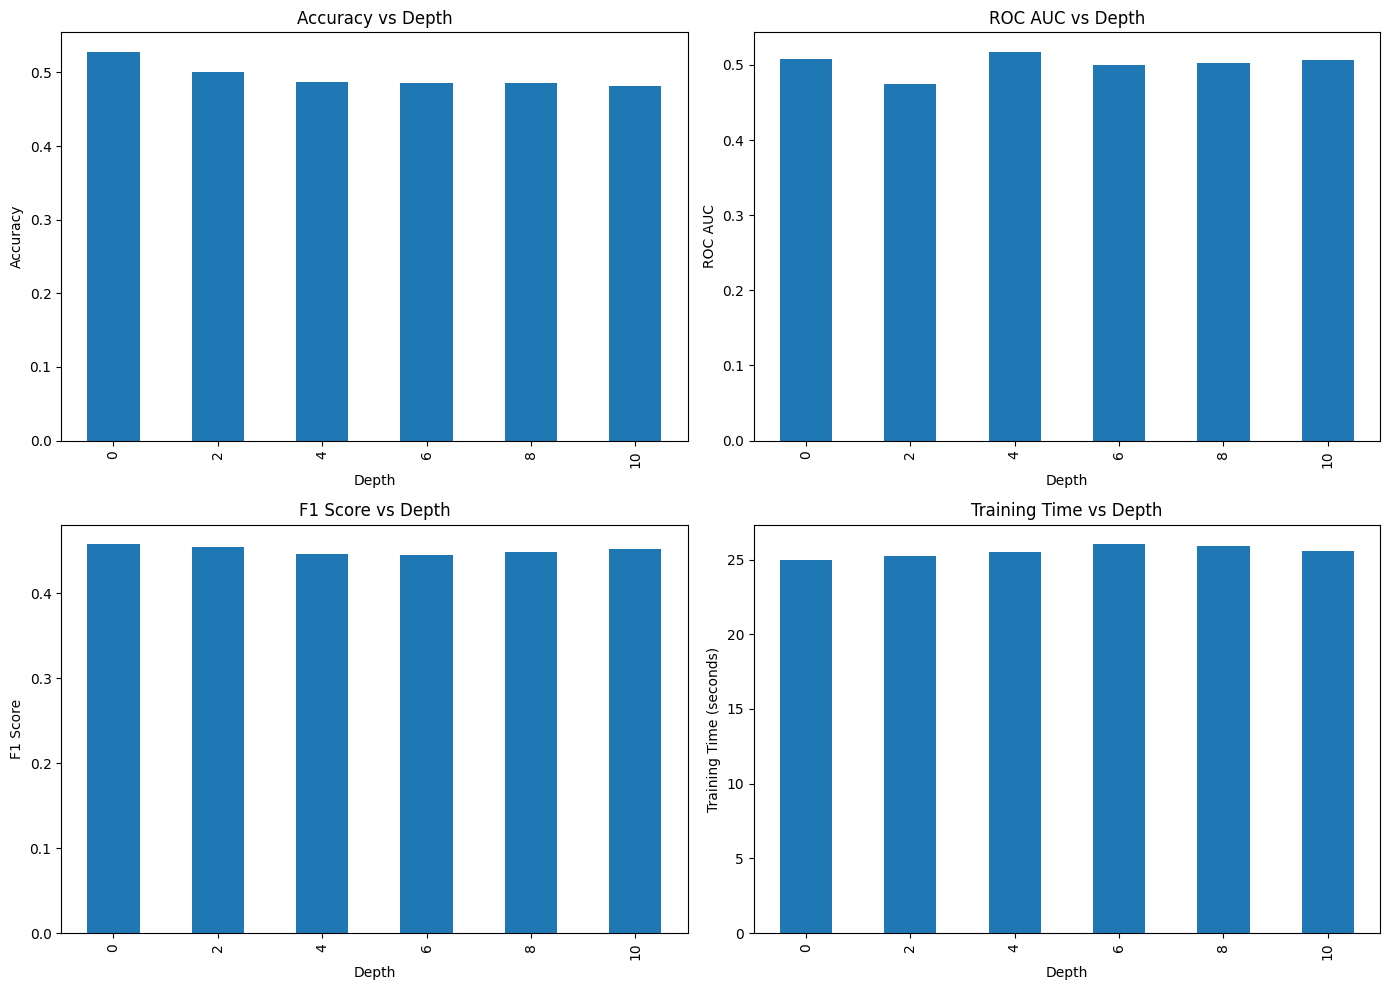

In [27]:
depth_results = pd.DataFrame(depth_results).T
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy bar plot
depth_results['accuracy'].plot(kind='bar', ax=axes[0,0], title='Accuracy vs Depth')
axes[0,0].set_xlabel('Depth')
axes[0,0].set_ylabel('Accuracy')

# ROC AUC bar plot
depth_results['roc_auc'].plot(kind='bar', ax=axes[0,1], title='ROC AUC vs Depth')
axes[0,1].set_xlabel('Depth')
axes[0,1].set_ylabel('ROC AUC')

# F1 Score bar plot
depth_results['f1_score'].plot(kind='bar', ax=axes[1,0], title='F1 Score vs Depth')
axes[1,0].set_xlabel('Depth')
axes[1,0].set_ylabel('F1 Score')

# Training Time bar plot
depth_results['training_time'].plot(kind='bar', ax=axes[1,1], title='Training Time vs Depth')
axes[1,1].set_xlabel('Depth')
axes[1,1].set_ylabel('Training Time (seconds)')

# Display the plots
plt.tight_layout()
plt.show()

In [28]:
def load_and_preprocess_images(data_paths, img_sz, batch_size):
    images = []
    labels = []
    for img_path in data_paths[:batch_size]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_sz, img_sz))
            img = img / 255.0
            images.append(img)
            # Assuming the labels are part of the file path
            if 'benign' in img_path:
                labels.append(0)
            elif 'malignant' in img_path:
                labels.append(1)
            else:
                labels.append(2)
    images = np.array(images).reshape(-1, img_sz, img_sz, 1)
    labels = tf.keras.utils.to_categorical(labels, num_classes=3)
    return images, labels

In [29]:
# Function to preprocess a single image
def preprocess_image(img_path, img_sz):
    img = image.load_img(img_path, target_size=(img_sz, img_sz))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Function to get the Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to apply heatmap to the original image
def apply_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + original_img
    return superimposed_img

# Function to load and preprocess images
def load_and_preprocess_images(data_paths, img_sz, batch_size):
    images = []
    labels = []
    for img_path in data_paths[:batch_size]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_sz, img_sz))
            img = img / 255.0
            images.append(img)
            # Assuming the labels are part of the file path
            if 'benign' in img_path:
                labels.append(0)
            elif 'malignant' in img_path:
                labels.append(1)
            else:
                labels.append(2)
    images = np.array(images).reshape(-1, img_sz, img_sz, 1)
    labels = tf.keras.utils.to_categorical(labels, num_classes=3)
    return images, labels

# Function to generate Grad-CAM for a batch of images
def generate_gradcam_batch_by_label(model, data_paths, img_sz, batch_size, last_conv_layer_name, alpha=0.4):
    # Load and preprocess images
    images, labels = load_and_preprocess_images(data_paths, img_sz, batch_size)
    
    # Separate images by labels
    benign_images = [images[i] for i in range(len(images)) if np.argmax(labels[i]) == 0]
    malignant_images = [images[i] for i in range(len(images)) if np.argmax(labels[i]) == 1]
    normal_images = [images[i] for i in range(len(images)) if np.argmax(labels[i]) == 2]

    # Define the maximum number of images per label
    max_images_per_label = 5

    # Select images and corresponding labels for each class
    selected_benign = benign_images[:max_images_per_label]
    selected_malignant = malignant_images[:max_images_per_label]
    selected_normal = normal_images[:max_images_per_label]
    
    # Create the plot layout for 3 columns (one per label) and 5 rows
    plt.figure(figsize=(15, 15))  # Adjust size as needed
    
    for i in range(max_images_per_label):
        if i < len(selected_benign):
            img_array = np.expand_dims(selected_benign[i], axis=0)
            heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
            original_img = (selected_benign[i] * 255).astype(np.uint8)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
            superimposed_img = apply_heatmap(heatmap, original_img, alpha)
            superimposed_img = np.clip(superimposed_img, 0, 255)
            plt.subplot(max_images_per_label, 3, i * 3 + 1)
            plt.imshow(superimposed_img / 255.0)
            plt.title("Label: Benign")
            plt.axis('off')
        
        if i < len(selected_malignant):
            img_array = np.expand_dims(selected_malignant[i], axis=0)
            heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
            original_img = (selected_malignant[i] * 255).astype(np.uint8)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
            superimposed_img = apply_heatmap(heatmap, original_img, alpha)
            superimposed_img = np.clip(superimposed_img, 0, 255)
            plt.subplot(max_images_per_label, 3, i * 3 + 2)
            plt.imshow(superimposed_img / 255.0)
            plt.title("Label: Malignant")
            plt.axis('off')
        
        if i < len(selected_normal):
            img_array = np.expand_dims(selected_normal[i], axis=0)
            heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
            original_img = (selected_normal[i] * 255).astype(np.uint8)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
            superimposed_img = apply_heatmap(heatmap, original_img, alpha)
            superimposed_img = np.clip(superimposed_img, 0, 255)
            plt.subplot(max_images_per_label, 3, i * 3 + 3)
            plt.imshow(superimposed_img / 255.0)
            plt.title("Label: Normal")
            plt.axis('off')
    
    plt.show()


# Example usage:
folder_name = 'Dataset_BUSI_with_GT'
files_names = ['benign', 'malignant', 'normal']
img_sz = 100  # Ensure this matches the input size your model expects
batch_size = 1000

# Load data paths
data_paths, labels = load_data_paths(folder_name=folder_name, files_names=files_names)


In [30]:
# Apply Grad-CAM to the batch of images
grad_cam_model = create_dynamic_model(100,10)
grad_cam_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 32)        0

In [31]:
def get_last_conv_layer_name(model):
    # Iterate through the layers in reverse order
    for layer in reversed(model.layers):
        # Check if the layer is a Conv2D layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # If no Conv2D layer is found

get_last_conv_layer_name(grad_cam_model)

'conv2d_5'

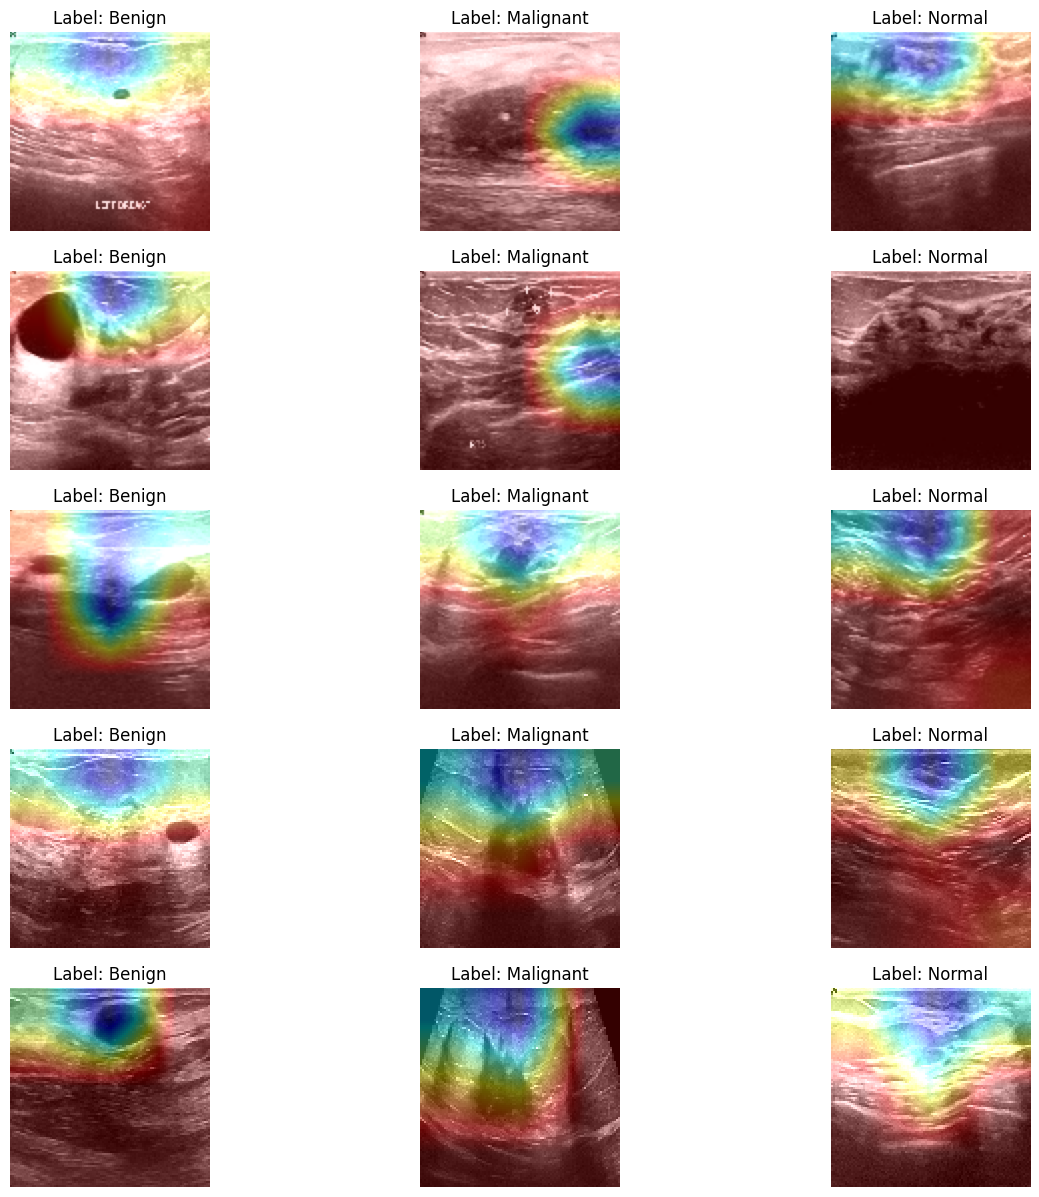

In [32]:
# Define the name of the last convolutional layer
last_conv_layer_name = get_last_conv_layer_name(grad_cam_model) #'conv2d_107'  # Replace with the actual name from your model summary

# Apply Grad-CAM to the batch of images
generate_gradcam_batch_by_label(grad_cam_model, data_paths, img_sz, batch_size, last_conv_layer_name)

In [33]:
def create_dynamic_model_version2(img_sz, model_depth_blocks, l2_strength=0.00001, dropout_rate=0.1):
    model = Sequential()
    
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu', 
                     kernel_regularizer=l2(l2_strength), input_shape=(img_sz, img_sz, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    current_size = img_sz
    for i in range(1, model_depth_blocks):
        if current_size <= 3:
            break
        num_filters = 8 * (2 ** i)
        model.add(Conv2D(num_filters, (3, 3), padding='same', activation='relu', 
                         kernel_regularizer=l2(l2_strength)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))
        current_size = current_size // 2

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [34]:
results = evaluate_model_stratified_kfold(
        folder_name=folder_name, 
        files_names=files_names, 
        img_sz=100, 
        create_model_func=create_dynamic_model_version2, 
        n_splits=5, 
        epochs=4, 
        batch_size=50, 
        model_depth_blocks=4
    )

Epoch 1/4
12/12 [==============================] - 4s 286ms/step - loss: 2.1796 - accuracy: 0.4917 - val_loss: 1.4959 - val_accuracy: 0.2667
Epoch 2/4
12/12 [==============================] - 3s 236ms/step - loss: 0.9304 - accuracy: 0.5505 - val_loss: 2.4124 - val_accuracy: 0.2800
Epoch 3/4
12/12 [==============================] - 2s 211ms/step - loss: 0.7842 - accuracy: 0.6690 - val_loss: 3.5443 - val_accuracy: 0.2600
Epoch 4/4
3/3 [==============================] - 1s 215ms/step
Epoch 1/4
12/12 [==============================] - 4s 284ms/step - loss: 2.3092 - accuracy: 0.4583 - val_loss: 1.5345 - val_accuracy: 0.2600
Epoch 2/4
12/12 [==============================] - 3s 234ms/step - loss: 0.9348 - accuracy: 0.5836 - val_loss: 2.9437 - val_accuracy: 0.2600
Epoch 3/4
12/12 [==============================] - 2s 218ms/step - loss: 0.8652 - accuracy: 0.6307 - val_loss: 4.3556 - val_accuracy: 0.2667
Epoch 4/4
3/3 [==============================] - 0s 199ms/step
Epoch 1/4
12/12 [===========

In [35]:
results

({'accuracy': 0.25333333333333335,
  'roc_auc': 0.5183941397529794,
  'f1_score': 0.11368794326241136,
  'training_time': 11.856422233581544},
 [{'loss': [2.179624080657959,
    0.9303816556930542,
    0.7841653227806091,
    0.7539000511169434],
   'accuracy': [0.49166667461395264,
    0.5505226254463196,
    0.6689895391464233,
    0.6550522446632385],
   'val_loss': [1.4958908557891846,
    2.412435293197632,
    3.5443408489227295,
    4.361612319946289],
   'val_accuracy': [0.2666666805744171,
    0.2800000011920929,
    0.25999999046325684,
    0.273333340883255]},
  {'loss': [2.309164524078369,
    0.9347968101501465,
    0.865200936794281,
    0.8129716515541077],
   'accuracy': [0.4583333432674408,
    0.5836237072944641,
    0.6306620240211487,
    0.6655052304267883],
   'val_loss': [1.5345056056976318,
    2.943748712539673,
    4.355631351470947,
    5.6355299949646],
   'val_accuracy': [0.25999999046325684,
    0.25999999046325684,
    0.2666666805744171,
    0.2666666805

In [36]:
depth_results

,accuracy,roc_auc,f1_score,training_time
0,0.528000,0.508064,0.457717,24.990348
2,0.500000,0.474061,0.454644,25.258167
4,0.486667,0.517604,0.445735,25.508767
6,0.485333,0.500482,0.445307,26.024372
8,0.485333,0.503293,0.448521,25.903965
10,0.481333,0.507187,0.451650,25.544319


In [37]:
def plot_fold_metrics(training_histories):
    n_folds = len(training_histories)
    plt.figure(figsize=(14, 5 * n_folds))

    for i, history in enumerate(training_histories):
        # Plot loss
        plt.subplot(n_folds, 2, 2 * i + 1)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {i + 1} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(n_folds, 2, 2 * i + 2)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {i + 1} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [38]:
def create_dynamic_model_version3(img_sz, model_depth_blocks, l2_strength=0.000005, dropout_rate=0.05):
    model = Sequential()
    
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu', 
                     kernel_regularizer=l2(l2_strength), input_shape=(img_sz, img_sz, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    current_size = img_sz
    for i in range(1, model_depth_blocks):
        if current_size <= 3:
            break
        num_filters = 8 + 8 * i  # Gradually increasing the filters
        model.add(Conv2D(num_filters, (3, 3), padding='same', activation='relu', 
                         kernel_regularizer=l2(l2_strength)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))
        current_size = current_size // 2

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [39]:
# Re-evaluate with the updated model
results, history = evaluate_model_stratified_kfold(
        folder_name=folder_name, 
        files_names=files_names, 
        img_sz=300, 
        create_model_func=create_dynamic_model_version3, 
        n_splits=5, 
        epochs=30, 
        batch_size=50, 
        model_depth_blocks=4,
        training_histories=True,
        l2_strength=0.001,
        dropout_rate=0.25
    )

Epoch 1/30
12/12 [==============================] - 10s 748ms/step - loss: 6.8603 - accuracy: 0.4533 - val_loss: 6.4788 - val_accuracy: 0.1733
Epoch 2/30
12/12 [==============================] - 8s 695ms/step - loss: 2.8761 - accuracy: 0.5627 - val_loss: 14.8286 - val_accuracy: 0.2075
Epoch 3/30
12/12 [==============================] - 8s 681ms/step - loss: 1.6624 - accuracy: 0.6254 - val_loss: 19.4869 - val_accuracy: 0.1698
Epoch 4/30
12/12 [==============================] - 8s 707ms/step - loss: 1.5415 - accuracy: 0.5976 - val_loss: 23.4934 - val_accuracy: 0.1415
Epoch 5/30
12/12 [==============================] - 8s 684ms/step - loss: 1.3985 - accuracy: 0.6516 - val_loss: 23.8924 - val_accuracy: 0.1887
Epoch 6/30
12/12 [==============================] - 8s 667ms/step - loss: 1.3571 - accuracy: 0.6568 - val_loss: 25.4792 - val_accuracy: 0.1887
Epoch 7/30
12/12 [==============================] - 8s 659ms/step - loss: 1.2741 - accuracy: 0.6864 - val_loss: 26.3034 - val_accuracy: 0.1509

In [40]:
results

{'accuracy': 0.24266666666666667,
 'roc_auc': 0.49920291438074765,
 'f1_score': 0.12368176943386358,
 'training_time': 242.51878933906556}

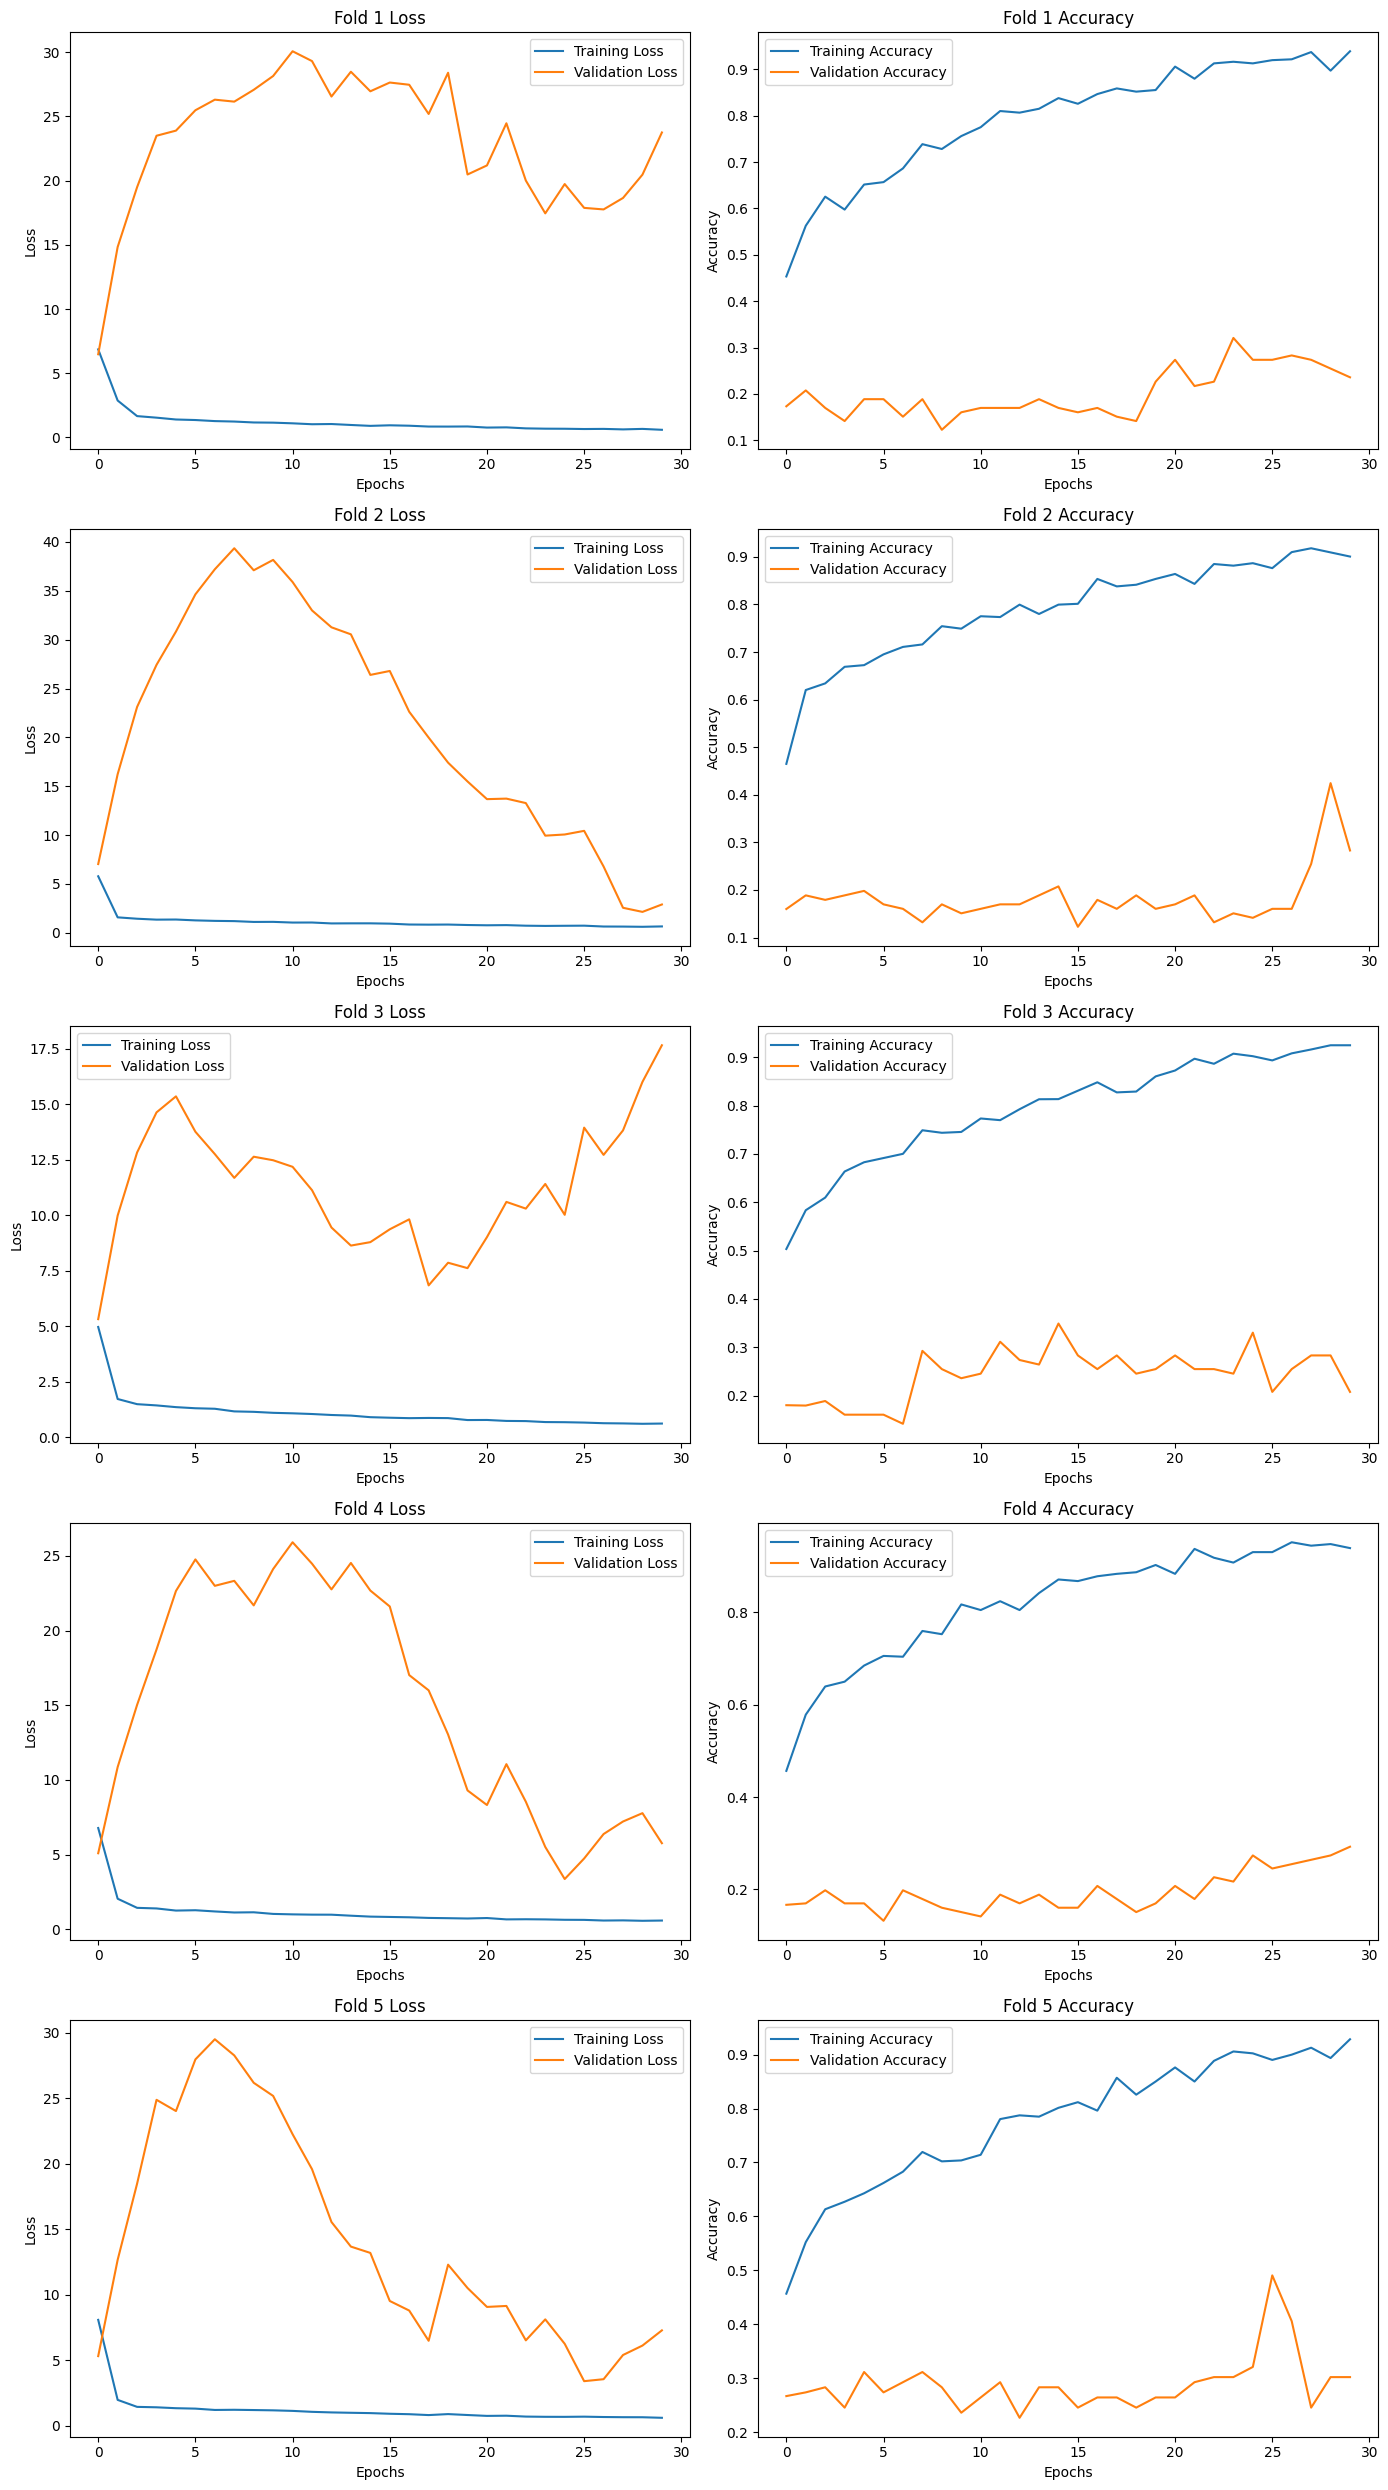

In [41]:
plot_fold_metrics(history)

In [42]:
total_time_end = time.time()

print((total_time_end - total_time_start)/60)

59.179374714692436
